# Fail/Pass tests and the implied failure rate and confidence levels

Let's say we conduct a fail/pass test. 
We subject $n_\mathrm{s}$ samples to an accelerated (representative) life test of $m=1$ lifetime equivalents. 
The test is considered a success if $100\,\%$ of the $n_\mathrm{s}$ samples survive. 
Yet, this leaves the important question of how certain can we be that the population as a whole (from which the $n_\mathrm{s}$ samples are a representative sub-set) will survive the $m=1$ lifetime equivalents? 
And, apart from the implied confidence level, what fraction of the population is still expected to fail even if $100\,\%$ of the $n_\mathrm{s}$ samples did survive? 

We consider a binomial distribution: the samples either survive (pass), or die (fail). 
Each sample has a probability $p$ of dying. 
Hence, starting with $n_\mathrm{s}$ samples, the probability of ending up with $k$ dead (failed) samples is

$$
B(k) = \frac{n_\mathrm{s}!}{k!(n_\mathrm{s}-k)!} p^k (1-p)^{(n_\mathrm{s}-k)}.
$$

The case of interest is with $k=0$ dead samples at the end of the test, i.e. all passed. 
This leaves us with the special case of

$$
B(0) = (1-p)^{n_\mathrm{s}}.
$$

With $p$ being the probability of dying, $(1-p)=R$ can be said to be a measure of the reliability (in the sense of the probability to survive the foreseen lifetime) of the devices being tested. 
The probability $B(0)$ represents a measure of how often we expect to see this survival rate. 
In other words, it is $B(0)=(1-C)$, with $C$ the confidence level.

Put together we find an expression of how $n_\mathrm{s}$ relates to $R$ and $C$:

$$
n_\mathrm{s} = \frac{\ln(1-C)}{\ln(R)}.
$$

We can reuse already tested samples and expose them to the accelerated life test a second, third, ... , $m$ time. 
Up to a certain point this would be equivalent a higher number of samples. 
Written differently,

$$
n_\mathrm{s} = m \times n_\mathrm{actual\_samples},
$$

and thus

$$
n_\mathrm{s} = \frac{\ln(1-C)}{m \ln(R)}.
$$

Sidenote, it should be clear that a test conducted with only one sample but which was exposed to $m=100$ lifetimes would NOT be statistically equally meaningful as a test with $100$ samples exposed to $m=1$ lifetime. 
In what context $m>1$ might be meaningful depends on various circumstances.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline


## Analytical examples

In [2]:
C = 0.9
R = 0.9
m = 1
n_s = np.log(1-C)/(m * np.log(R))

print("""
In the case we want to be $C=90\%$ confident that the whole population shows a $R=90\%$ reliability 
(i.e. at least $90\%$ of the whole will survive duration $m$),
the minimum number of samples to test is 

n_s = {:.2f}
""".format(n_s))


In the case we want to be $C=90\%$ confident that the whole population shows a $R=90\%$ reliability 
(i.e. at least $90\%$ of the whole will survive duration $m$),
the minimum number of samples to test is 

n_s = 21.85



In [3]:
m = 1
n_s = 77
R = 0.95

# (1-C) = B(0) = (1-p)^n = R^n
C = 1 - R**n_s

print("""
Given m={}, n_s={}, and an assumed reliability of R={}%, the confidence level is

C = {:.2f}%.
""".format(m, n_s, R*100, C*100))


Given m=1, n_s=77, and an assumed reliability of R=95.0%, the confidence level is

C = 98.07%.



## Numerical examples

Given $n_\mathrm{s}$ samples which each have an (assumed) intrinsic reliability $R$, how often would we run a test without any sample failing? 
This rate of at least one failure represents our confidence level that we would have encountered at least one failing sample if the underlying reliability was lower than the assumed $R$.


In [5]:
class Device:
    def __init__(self, intrinsic_reliability):
        self._R = intrinsic_reliability
    
    def test(self):
        # test considered passed (i.e. device survived test) if
        # probability of intrinsic reliability is larger than outcome of random event
        return int( self._R > np.random.random() )

    
def conduct_test(test_battery):
    # return 1 = pass: all DUTs survived
    # return 0 = fail: at least 1 DUT died
    survival = 0
    for device in test_battery:
        survival += device.test()
    return int( survival==len(test_battery) )
        
    
# parameters to explore
reliabilities = [0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999]
n_samples = np.arange(2,100,5) # note: I want to cover n_s=22 and n_s=77 mentioned in the text above
N = 1000 # simulate N times, with N large to be statistically meaningful, but not too large to get the computer running forever
test_repetitions = np.arange(N)


# init results containers

# a multi-dimensional dictionary
# e.g. frequency_of_catching_subpar_samples[0.9][22] will contain the confidence level 
# for a device with an intrinsic reliability R=0.9 when tested with n_s=22 samples.
frequency_of_catching_subpar_samples = {}
for R in reliabilities: frequency_of_catching_subpar_samples[R] = {}
    
repetition_passed = np.zeros(N)


# simulating the accelerated life tests

for R in reliabilities:
    for n_s in n_samples:
        test_battery = [Device(R) for _ in range(n_s)]

        for rep in test_repetitions:
            repetition_passed[rep] = conduct_test(test_battery)

        frequency_of_catching_subpar_samples[R][n_s] = 1-np.mean(repetition_passed)



print("Confidence level of detecting fact that population shows reliability of <R given n_s samples is")
        
def print_summary(R, n_s):
    print("R={}, n_s={}".format(R,n_s), "--> C=",frequency_of_catching_subpar_samples[R][n_s])
    
print_summary(0.9, 22)
print_summary(0.95, 77)
print_summary(0.99, max(n_samples))

Confidence level of detecting fact that population shows reliability of <R given n_s samples is
R=0.9, n_s=22 --> C= 0.888
R=0.95, n_s=77 --> C= 0.981
R=0.99, n_s=97 --> C= 0.631


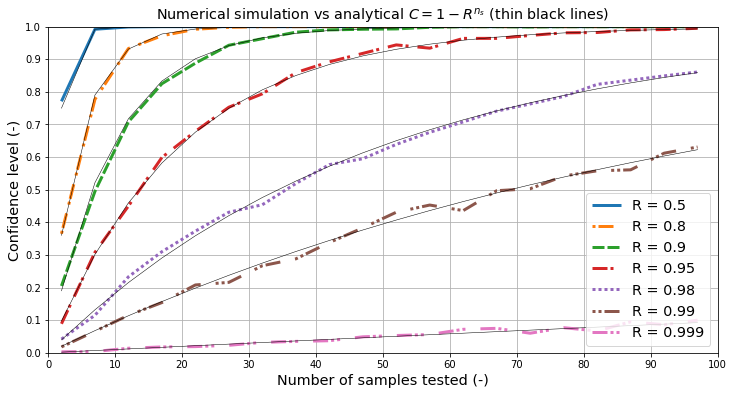

In [7]:
plt.figure(figsize=(12,6))

linestyles = [(0,()), 
              (0,(1,1,5,3)),
              (0,(4,1)), 
              (0,(5,1,1,3)), 
              (0,(1,1)), 
              (0,(1,1,1,1,5,5)), 
              (0,(5,1,1,1,1,5))]
linewidth = 3

for j, p in enumerate(reliabilities):
    confidence_of_catching_p_reliable_failures = [frequency_of_catching_subpar_samples[p][n_s] for n_s in n_samples]
    plt.plot(n_samples, confidence_of_catching_p_reliable_failures, label="R = {}".format(p), 
             linestyle=linestyles[j], linewidth=linewidth)
    plt.plot(n_samples, 1-p**n_samples, linestyle='-', linewidth=0.5, color='black')
plt.grid()

plt.xlim([0,100])
plt.ylim([0,1])
fontsize = 'x-large'
plt.legend(loc='best', fontsize=fontsize)

plt.title("Numerical simulation vs analytical $C = 1 - R^{n_s}$ (thin black lines)", fontsize=fontsize)
plt.xlabel("Number of samples tested (-)", fontsize=fontsize)
plt.ylabel("Confidence level (-)", fontsize=fontsize)
plt.xticks(np.arange(0,101,10))
plt.yticks(np.linspace(0,1,11))
    

print("")